## A intenção do projeto é criar um chatbot baseado em reviews de filmes para que se possa fazer perguntas e manter uma conversa livre

- link do banco de dados https://www.kaggle.com/Cornell-University/movie-dialog-corpus?select=movie_lines.tsv
- referências
>- https://shanebarker.com/blog/deep-learning-chatbot/
> -https://towardsdatascience.com/how-to-create-a-chatbot-with-python-deep-learning-in-less-than-an-hour-56a063bdfc44

In [1]:
!pip3 install gensim
!pip3 install tensorflow
!pip3 install keras

In [1]:
import pandas as pd
import re
import gensim
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from scipy.spatial import distance

### Opening movie reviews

In [2]:
messages = pd.read_csv('./chatdata/movie_characters_metadata.tsv', header = None, delimiter="\t", quoting=3, encoding='ISO-8859-2')

In [3]:
messages.columns = ['user_id', 'user_name', 'movie_id', 'movie_name', 'tag_1', 'tag_2']

In [4]:
messages.head(10)

,user_id,user_name,movie_id,movie_name,tag_1,tag_2
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6
5,u5,KAT,m0,10 things i hate about you,f,2
6,u6,MANDELLA,m0,10 things i hate about you,f,7
7,u7,MICHAEL,m0,10 things i hate about you,m,5
8,u8,MISS PERKY,m0,10 things i hate about you,?,?
9,u9,PATRICK,m0,10 things i hate about you,m,1


### Data exploration

In [5]:
#setting parameters for data visualization
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

#### Data Analysis based on this article
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools?utm_source=medium&utm_medium=crosspost&utm_campaign=blog-exploratory-data-analysis-natural-language-processing-tools

In [20]:
!pip3 install \
   pandas matplotlib numpy \
   nltk seaborn sklearn gensim pyldavis \
   wordcloud textblob spacy textstat

     |████████████████████████████████| 283 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 770 kB/s eta 0:00:01
     |████████████████████████████████| 372 kB 760 kB/s eta 0:00:01
     |████████████████████████████████| 102 kB 1.1 MB/s ta 0:00:01
     |████████████████████████████████| 829 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 164 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 272 kB 1.0 MB/s eta 0:00:01     |███████████████████████████████▎| 266 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 307 kB/s eta 0:00:01
     |████████████████████████████████| 99 kB 138 kB/s eta 0:00:01     |██████▋                         | 20 kB 1.3 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=eb98d033320aa298d65cbc3d45ca4bf2effbff7824eea19bad49d2897846cdfc
  Stored in directory: /home/douglas/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da9

In [5]:
data = messages['user_name']

In [6]:
len(data)

9035

In [7]:
data.describe()

count     9035
unique    5357
top        MAN
freq        44
Name: user_name, dtype: object

### Number of characters of each message

<AxesSubplot:>

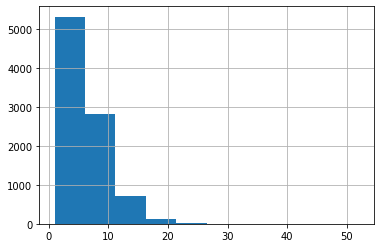

In [8]:
#histogram to display the number of character of each message
data.str.len().hist()

The number of characters are between 0 and 500

### Removing non-alphabetical messages

In [9]:
#there are some non-alphabetical messages that need to be found
data.loc[data.isna()].size

#the above statment does the same of this
#msg.loc[msg.isnull()].size

0

In [537]:
#filling the nan messages with a string
#messages = messages.fillna('.')

### Number of words for each message

<AxesSubplot:>

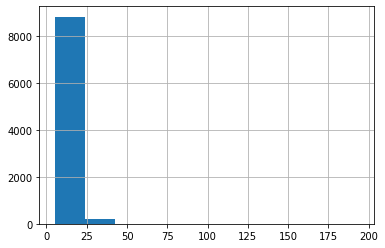

In [10]:
#number of words for each message
data.str.split(' ').\
    map(lambda x: len(str(x))).\
    hist()

The number of words are between 0 and 100

### Average word length

<AxesSubplot:>

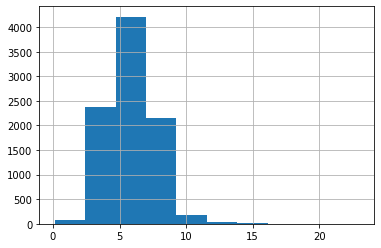

In [11]:
#checking the average word length
data.str.split(' ').\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

The length of words goes from 0 to 15

The word 'I' has the biggest occurrence. There are a lot of messages like dashes that can be removed

## Value types

In [12]:
#checking the average word length
data_set = [type(item) for item in data]
data_set = set(data_set)
data_set

{str}

## Print float values

In [13]:
[it for it in data if isinstance(it, float)]

[]

## Print user_id of nan user_names

In [14]:
messages[messages['user_name'].isna()]

,user_id,user_name,movie_id,movie_name,tag_1,tag_2


## Print long user_names

In [15]:
set([n for n in data if not(str(n).isupper())])

set()

In [26]:
[n for n in data if len(n) > 10]

NameError: name 'random' is not defined

- There are names with repeated white spaces
- special characters
- numbers
- 44 names 'MAN'

## Checking the row for MANs

In [22]:
messages[messages['user_name'] == 'MAN']

,user_id,user_name,movie_id,movie_name,tag_1,tag_2
610,u610,MAN,m38,bottle rocket,?,?
732,u732,MAN,m46,croupier,?,?
876,u876,MAN,m56,even cowgirls get the blues,?,?
963,u963,MAN,m62,frances,?,?
1101,u1101,MAN,m72,ghost world,?,?
1343,u1343,MAN,m89,highlander,?,?
1543,u1543,MAN,m103,it happened one night,?,?
1576,u1576,MAN,m104,jfk,?,?
1729,u1729,MAN,m114,lĂŠon,?,?
1860,u1860,MAN,m122,logan's run,?,?


user_id with same user_name

## Print duplicated names

In [30]:
dict = {}

In [31]:
type(dict)

dict

In [38]:
x = 'a'
if x in dict:
    dict[x] = dict[x] + 1
else:
    dict[x] = 0
    
print(dict)

{'a': 5}


In [39]:
dict = {}
for n in data:
    if n in dict:
        dict[n] = dict[n] + 1
    else:
        dict[n] = 1

In [40]:
dict

{'BIANCA': 4,
 'BRUCE': 8,
 'CAMERON': 3,
 'CHASTITY': 1,
 'JOEY': 9,
 'KAT': 3,
 'MANDELLA': 1,
 'MICHAEL': 18,
 'MISS PERKY': 1,
 'PATRICK': 6,
 'SHARON': 5,
 'WALTER': 13,
 'ALONSO': 1,
 'AROJAZ': 1,
 'BEATRIX': 1,
 'BOBADILLA': 1,
 'COLUMBUS': 1,
 'FERNANDO': 1,
 'ISABEL': 1,
 'MARCHENA': 1,
 'MENDEZ': 1,
 'MOXICA': 1,
 'PINZON': 1,
 'SAILOR': 2,
 'SANCHEZ': 4,
 'UTAPAN': 1,
 'CUTLER': 1,
 'DAPHNE': 1,
 'DUFFY': 5,
 'EDDIE': 14,
 'EMIL': 2,
 'HAWKINS': 1,
 'HONEY': 3,
 'IMMIGRATION OFFICER': 1,
 'JORDY': 1,
 'KORFIN': 1,
 'LEON': 7,
 'MAGGIE': 4,
 'MAX': 17,
 'MILOS': 1,
 'MUGGER': 2,
 'NICOLETTE': 2,
 'OLEG': 1,
 'ROBERT HAWKINS': 1,
 'ROSE': 12,
 'SECONDARY OFFICER': 1,
 'STEPHEN GELLER': 1,
 'TOMMY': 18,
 'VENDOR': 2,
 'B20': 1,
 'BOWMAN': 3,
 'C12': 1,
 'CHILD': 1,
 'CO-PILOT': 1,
 'ELENA': 4,
 'FLOYD': 4,
 'HAL': 5,
 'MICHAELS': 2,
 'MILLER': 5,
 'PILOT': 7,
 'POOLE': 1,
 'SMYSLOV': 1,
 'ATTENDANT': 6,
 'BARTENDER': 11,
 'BILLY': 21,
 'CANDY': 6,
 'CASEY': 3,
 'CATES': 1,
 'EL

There are a lot of duplicated names